In [1]:
import os
import sys
import numpy as np

import umap.umap_ as umap

#add the parent folder to sys path so we can import from the notebook subfolder
sys.path.insert(0,'..')


BASEDIR = ""
TIFDIR = "/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo"
#TIFDIR = "/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/NC_s4r2"
EXT='.tiff'

image_directory = os.path.join(BASEDIR, TIFDIR)
output_directory = os.path.join(image_directory, "outputs")

if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
#image_directory = ALLDIR

In [2]:
%load_ext autoreload
%autoreload 2

import xfmreadout.processops as processops
import xfmreadout.clustering as clustering
import xfmreadout.visualisations as vis

FORCE_EMBED=True
FORCE_CLUST=True
OVERWRITE=True

elements, data, dims, sd_data, sd_dims = processops.compile(image_directory)

data, dims = processops.data_crop(data, dims, 100, 500, 150, 350)

#data, elements, dims, sd_data, sd_dims = processops.compile(image_directory)

-----------------
BEGIN reading processed data
Location: /home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo
-----
Map files found: 20
Elements identified: ['Al', 'As', 'Ca', 'Cl', 'Compton', 'Cr', 'Cu', 'Fe', 'K', 'Mn', 'Mo', 'MoL', 'Ni', 'P', 'S', 'Si', 'Ti', 'V', 'Zn', 'sum']
-----------------
READING MAP DATA
Initial shape: (393, 700, 20)
Revised shape: (392, 700, 20)
-----
-----------------
READING VARIANCE DATA
Initial shape: (197, 350, 20)
-----
Al -- data: 0.054427698254585266, var: 1.4911073446273804, ratio: 54.79222500472953
As -- data: 0.0013860455946996808, var: 0.011784680187702179, ratio: 17.00475111752093
Ca -- data: 0.0773456022143364, var: 0.055722881108522415, ratio: 1.4408803994855677
Cl -- data: 0.003481516381725669, var: 0.12431034445762634, ratio: 71.41160967107669
Compton -- data: 5.356117216415157e-10, var: 1.7024261111941996e-08, ratio: 63.56941203514703
Cr -- data: 0.00429584551602602, var: 0.03232191130518913, ratio: 15.047985866628338
Cu -- data: 0

(80000,)
ELEMENT MAP: Si
Si, max: 3.98, 98: 3.52, avg: 0.70


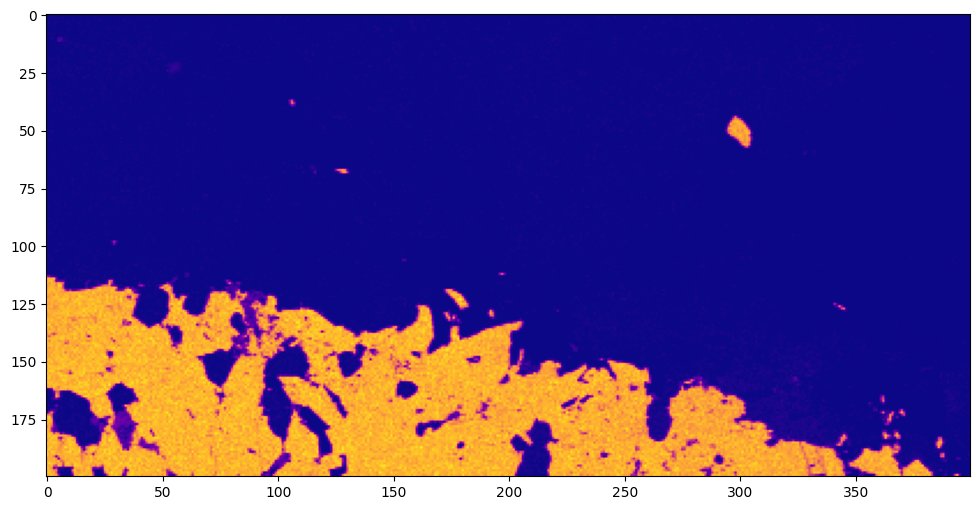

(68950,)
ELEMENT MAP: Si
Si, max: 3.58, 98: 3.47, avg: 0.98


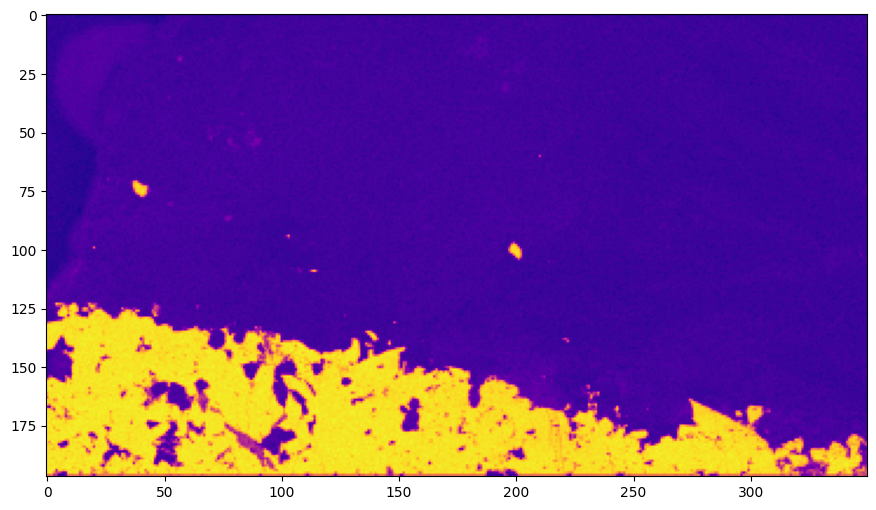

In [3]:
ELEMENT = "Si"

vis.show_map(data, dims, elements, ELEMENT)

vis.show_map(sd_data, sd_dims, elements, ELEMENT)

LOADING EMBED
LOADING CATS
---------------------------
CLASSIFICATION COMPLETE
---------------------------
total time: 0.0 s
time per pixel: 0.0 s
---------------------------
(80000, 3)
running reducer: PCA across data with shape: (80000, 3)
11
(80000,)
-1
0


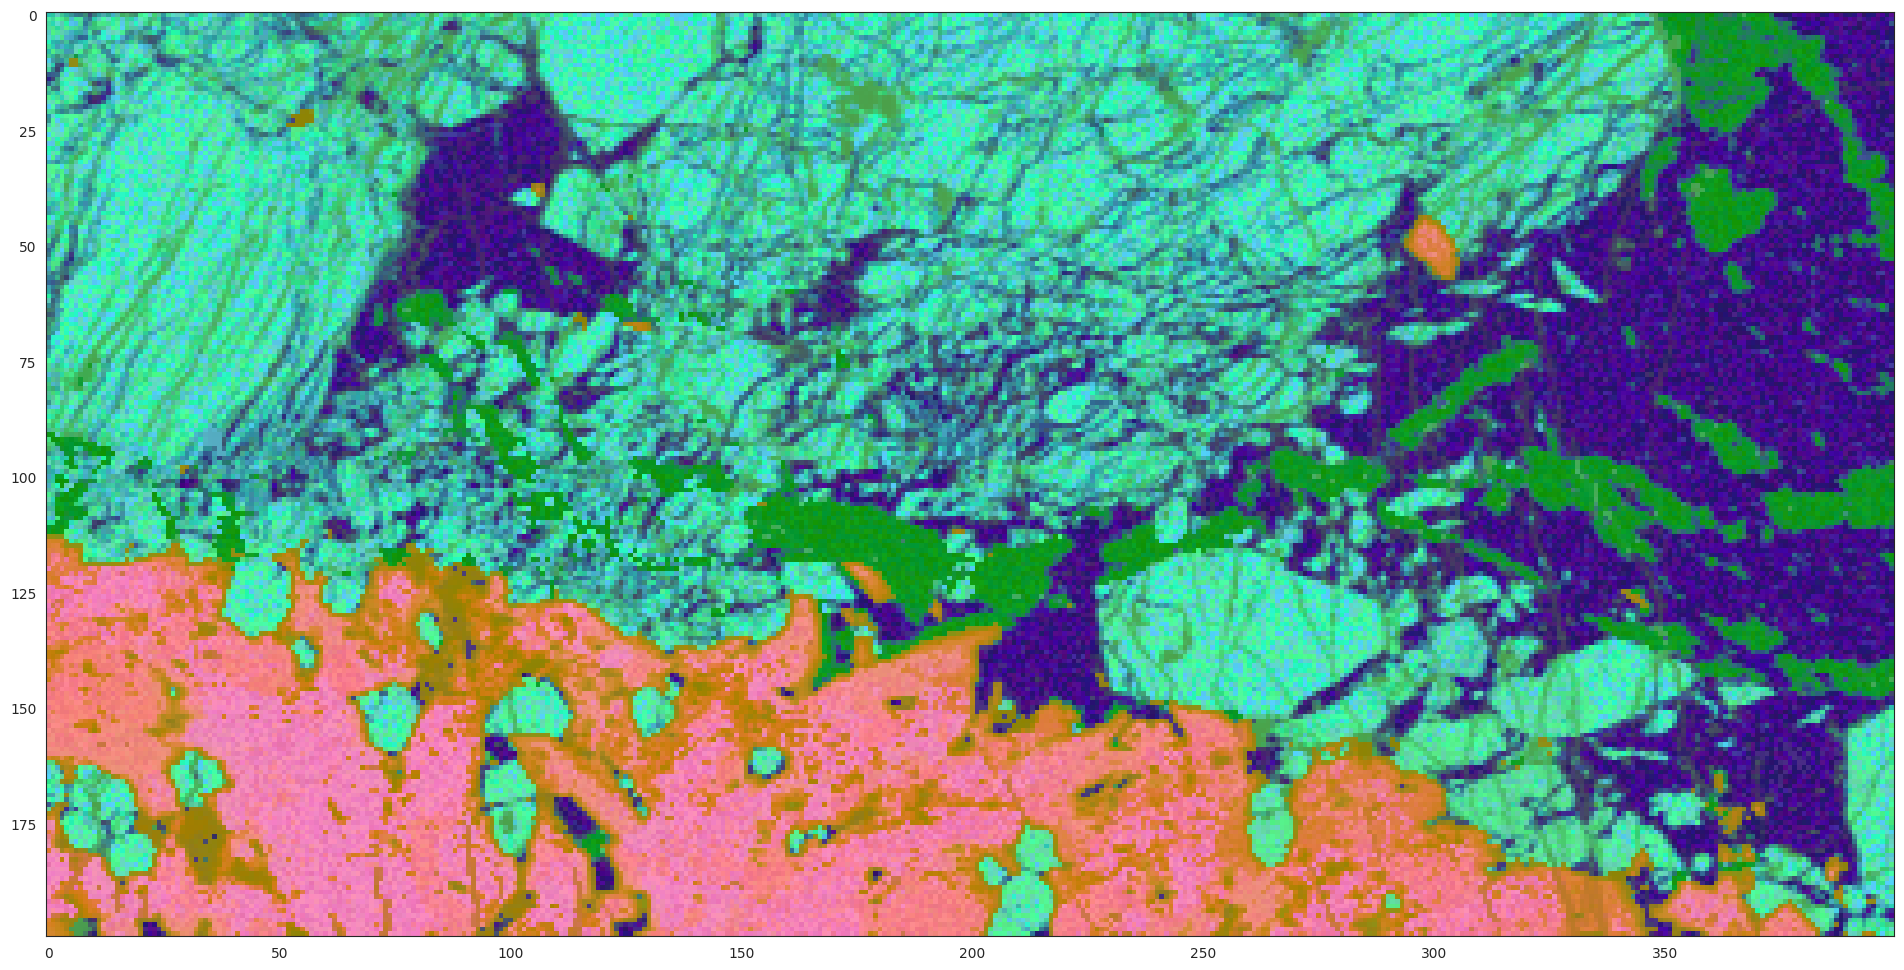

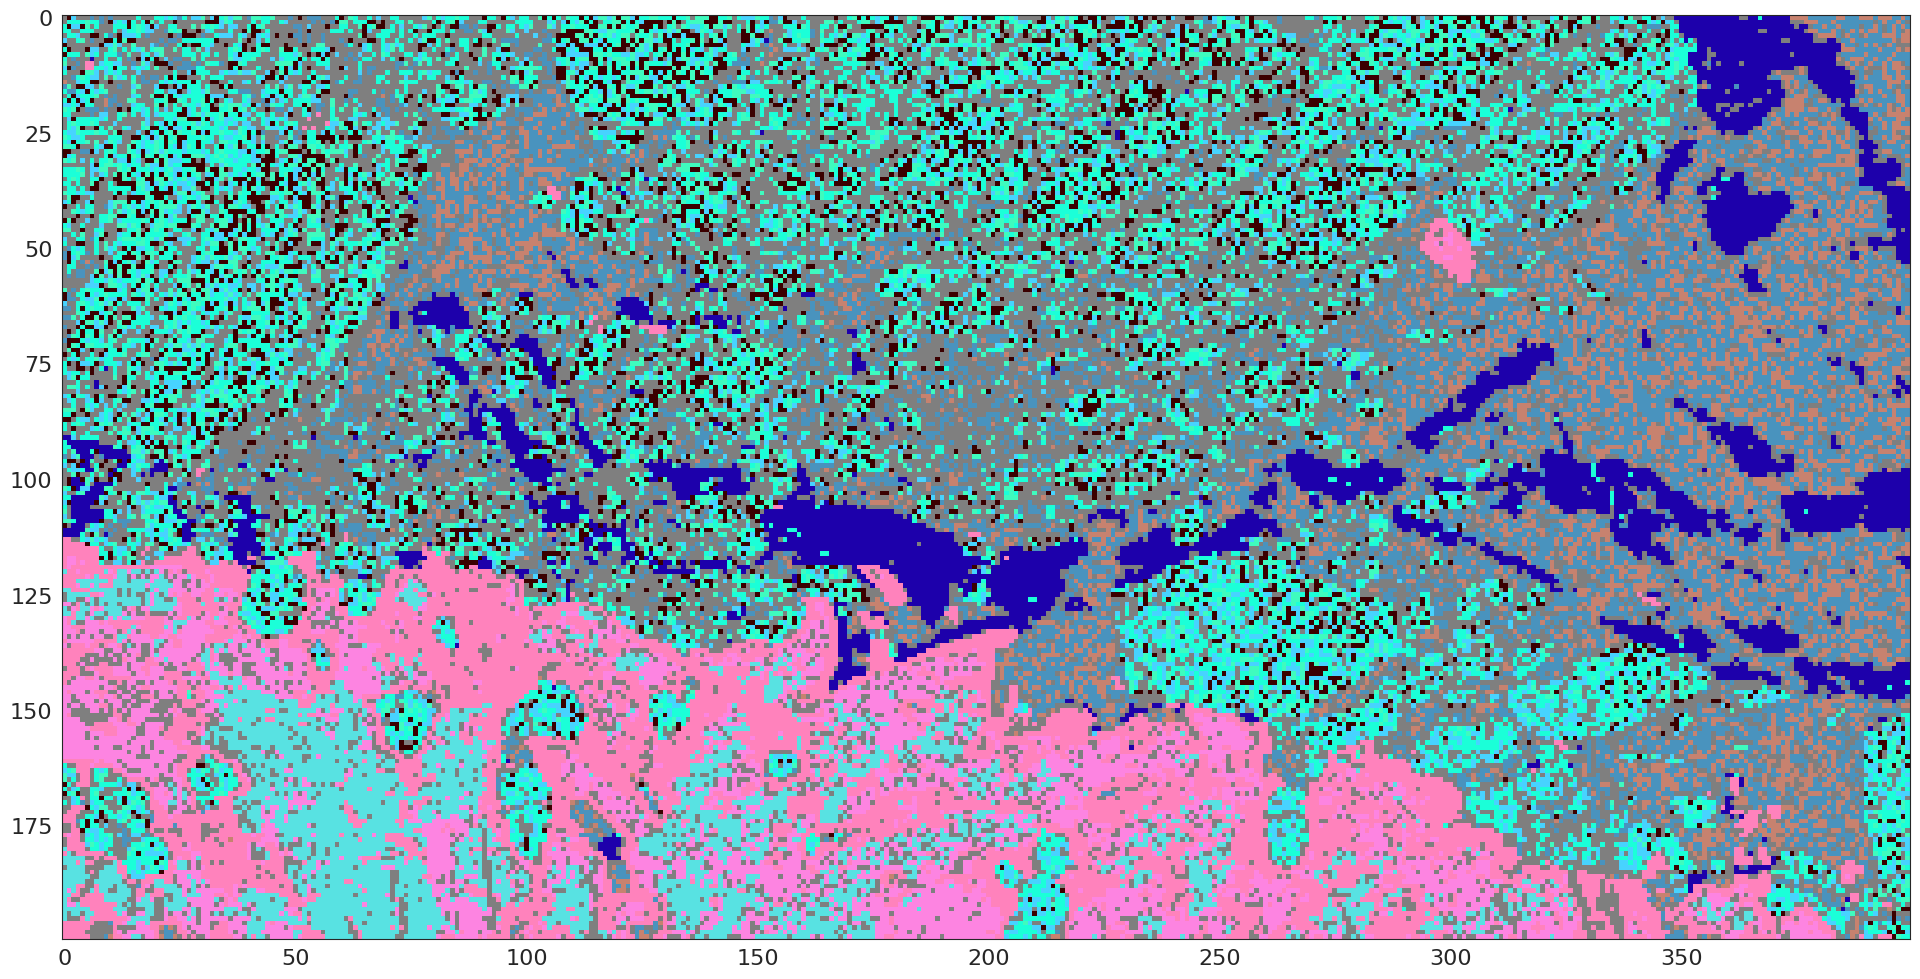

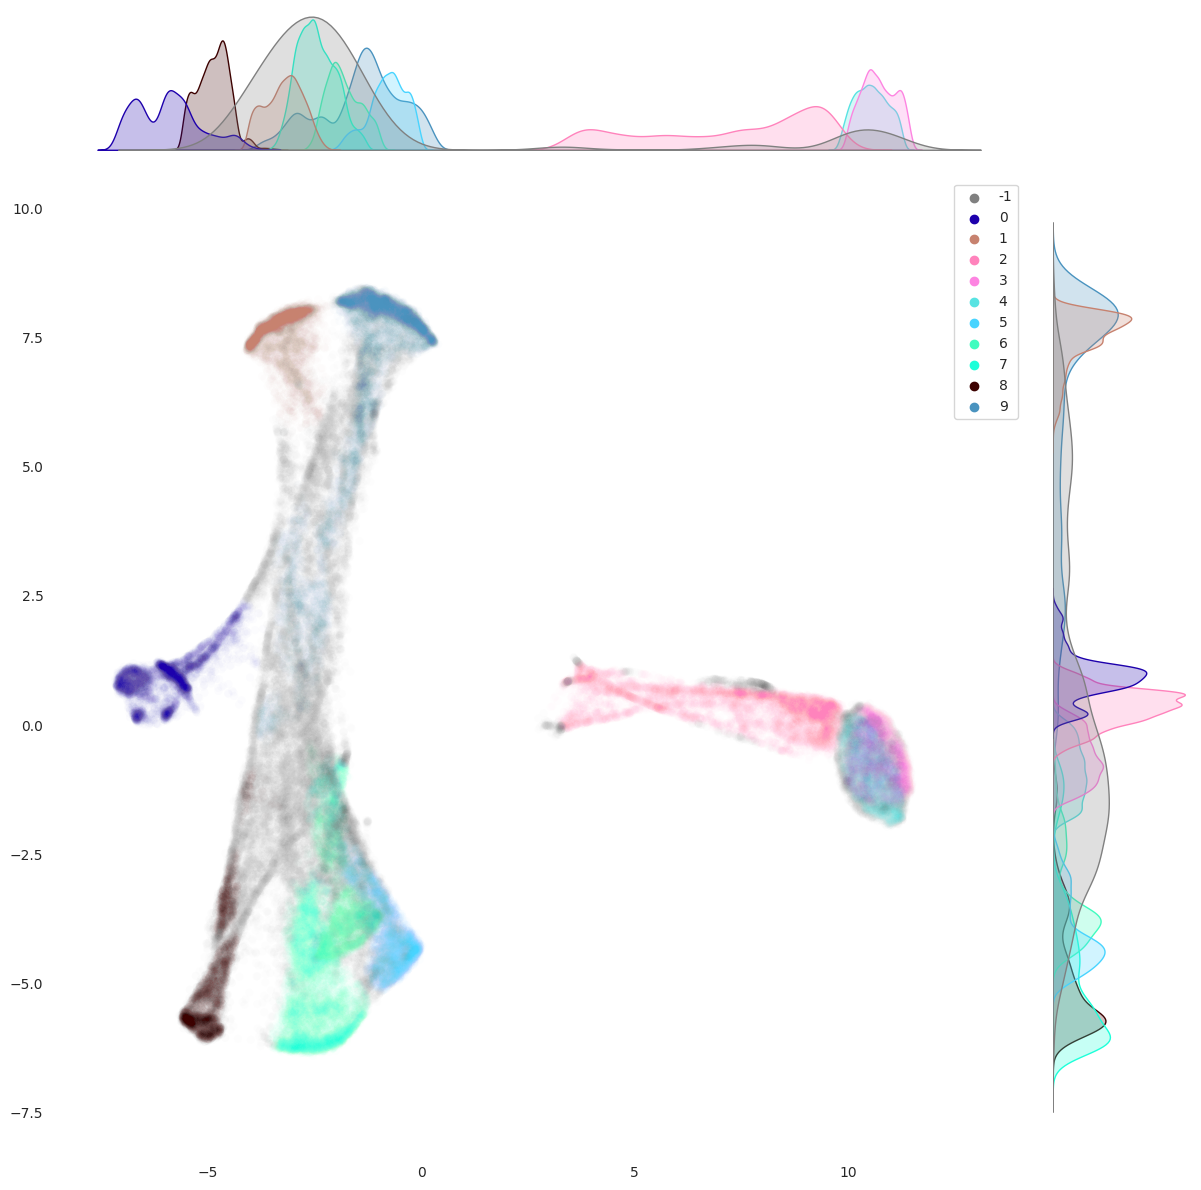

Al, max: 0.07, 98: 0.01, avg: 0.00
As, max: 0.00, 98: 0.00, avg: 0.00
Ca, max: 2.56, 98: 0.26, avg: 0.03
Cl, max: 0.00, 98: 0.00, avg: 0.00
Compton, max: 0.86, 98: 0.07, avg: 0.01
Cr, max: 0.00, 98: 0.00, avg: 0.00
Cu, max: 1.04, 98: 0.97, avg: 0.22
Fe, max: 3.34, 98: 3.13, avg: 2.00
K, max: 0.02, 98: 0.00, avg: 0.00
Mn, max: 0.26, 98: 0.02, avg: 0.01
Mo, max: 0.22, 98: 0.12, avg: 0.04
MoL, max: 0.03, 98: 0.00, avg: 0.00
Ni, max: 0.00, 98: 0.00, avg: 0.00
P, max: 0.00, 98: 0.00, avg: 0.00
S, max: 1.08, 98: 0.89, avg: 0.46
Si, max: 3.98, 98: 3.52, avg: 0.70
Ti, max: 0.02, 98: 0.00, avg: 0.00
V, max: 0.00, 98: 0.00, avg: 0.00
Zn, max: 0.43, 98: 0.03, avg: 0.00
sum, max: 0.87, 98: 0.75, avg: 0.44
CPU times: user 4.54 s, sys: 2.86 s, total: 7.4 s
Wall time: 3.6 s


In [25]:
%%time

FORCE_EMBED=False
FORCE_CLUST=False
OVERWRITE=False

categories, classavg, embedding = clustering.run(data, image_directory, sqrt=True, force_embed=FORCE_EMBED, force_clust=FORCE_CLUST, overwrite=OVERWRITE)

palette = vis.plot_clusters(categories, classavg, embedding, dims, output_directory=output_directory)

for i in range(len(elements)):
    print(f"{elements[i]}, max: {np.max(data[:,i]):.2f}, 98: {np.quantile(data[:,i],0.98):.2f}, avg: {np.average(data[:,i]):.2f}")





(80000,)
(80000,)
(80000,)
(80000,)


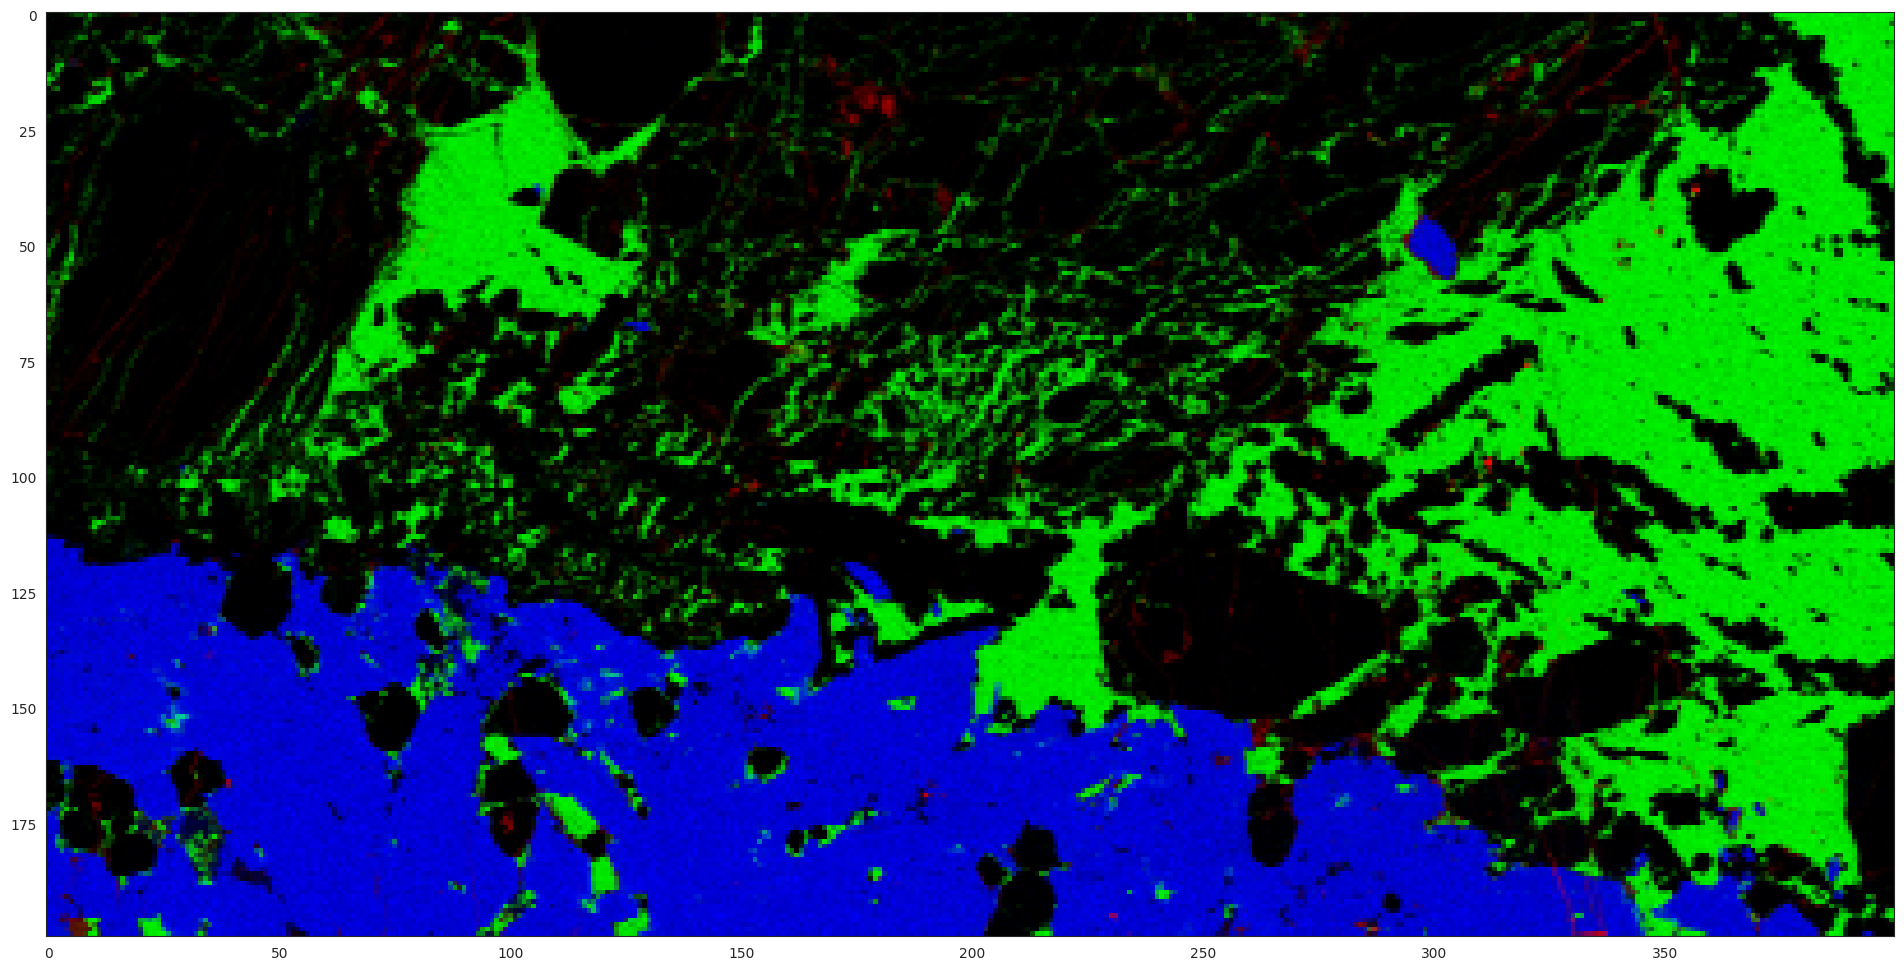

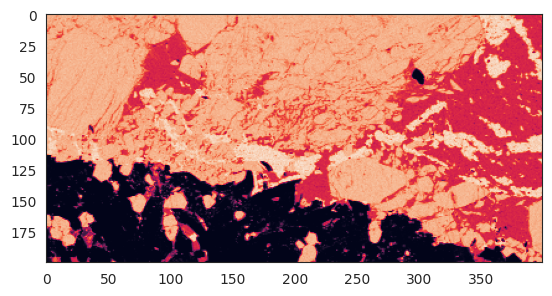

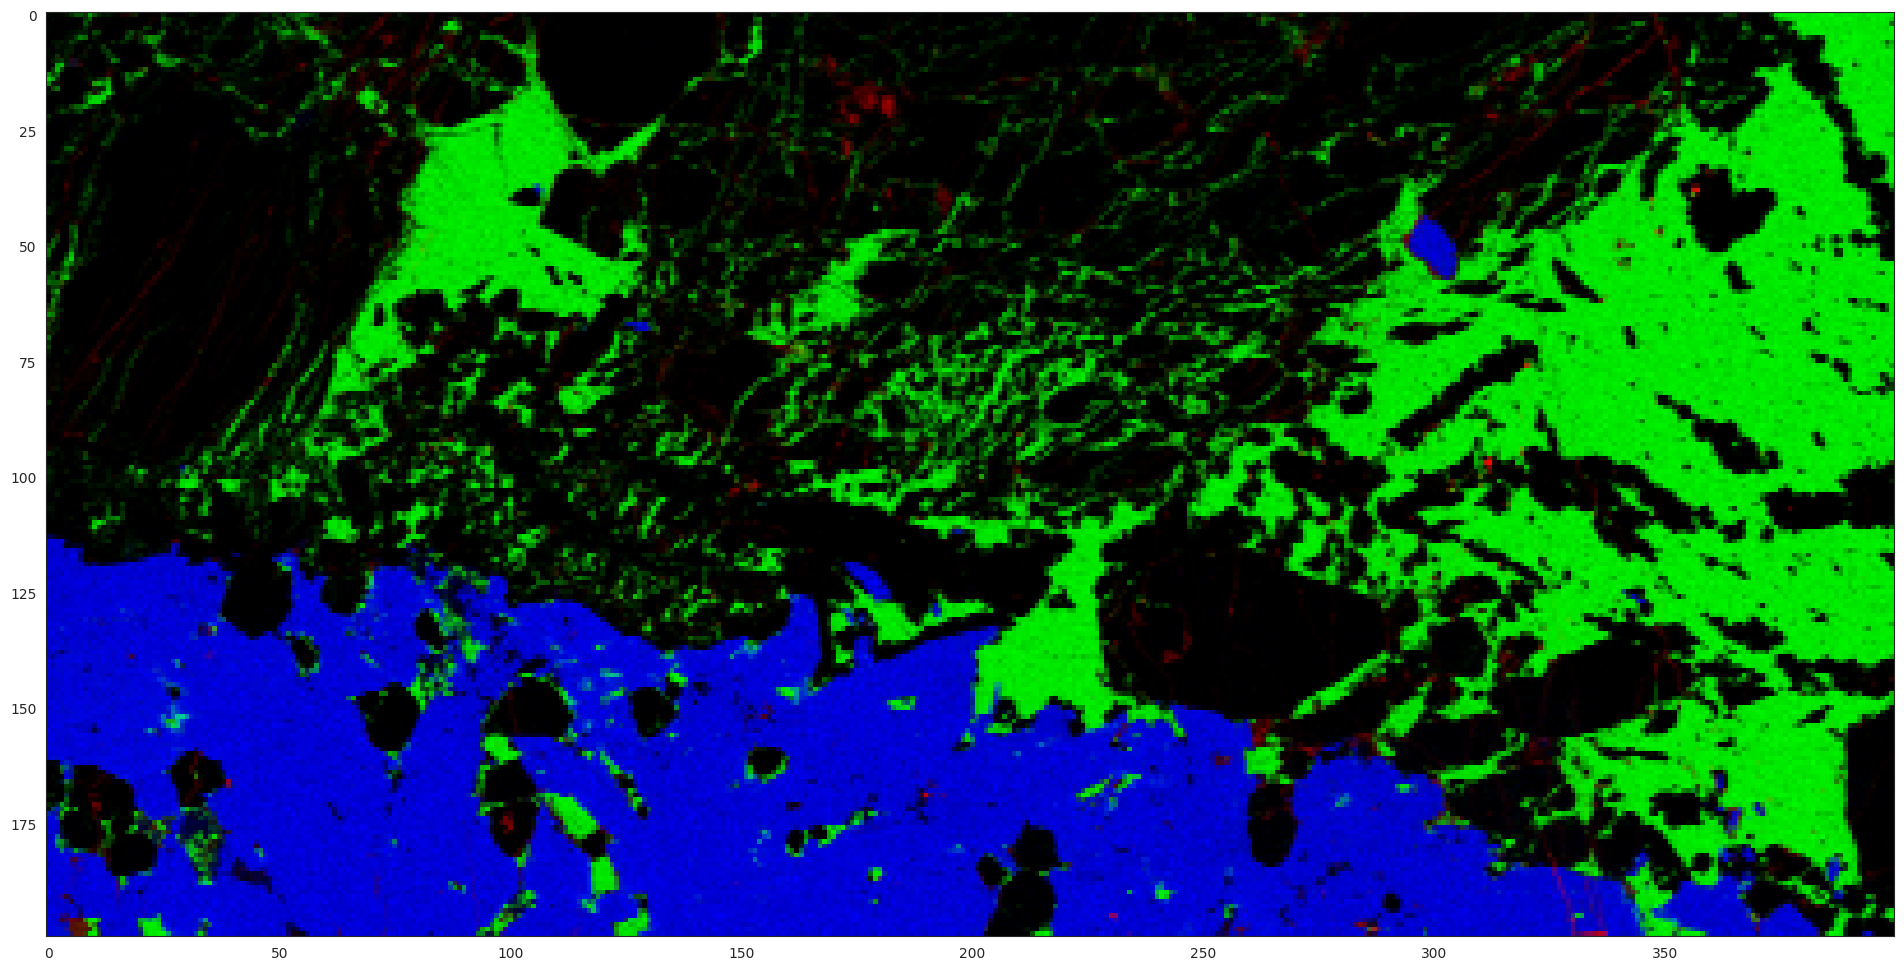

In [26]:
import xfmreadout.utils as utils
import xfmreadout.visualisations as vis

r = utils.get_map(data, dims, elements, 'Fe')
plt.imshow(r)

#vis.tricolour_enames('Fe','Cu','Si', data, dims, elements)
vis.tricolour_enames('Ca','Cu','Si', data, dims, elements)

/home/lachlan/CODEBASE/ReadoutXFM/notebooks/../xfmreadout/visualisations.py:203: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


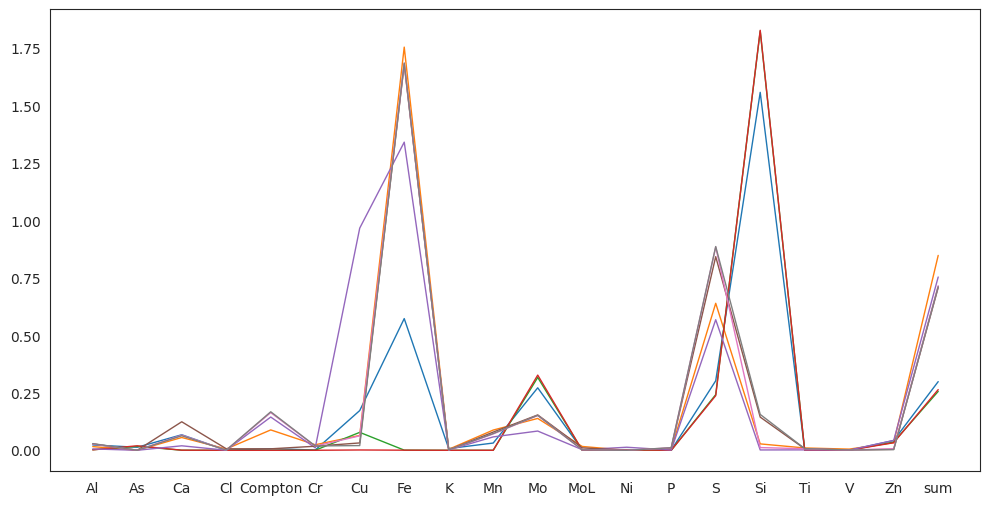

In [24]:
vis.category_avgs(categories, elements, classavg, palette=palette)